In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, normaltest
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

## Problématique :
Banque : Comment analyser les transactions bancaires pour identifier
des schémas de fraude ?

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


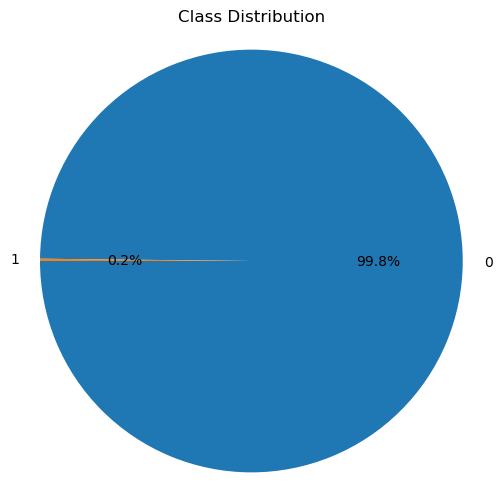

In [5]:
counts = df['Class'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=180)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

On voit vraiment qu'il y a un problème de distribution entre les Class, seulement environ 0.2% de cette base de données sont des fraudes

In [6]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

<Axes: >

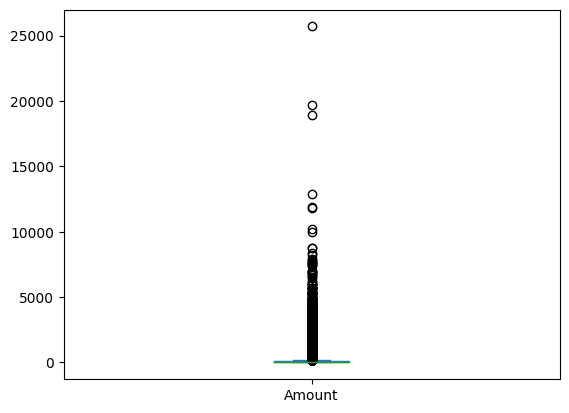

In [7]:
df['Amount'].plot(kind='box')

On voit qu'il y a énormement d'outliers, normalement, c'est un problème, mais on va faire avec pour l'instant

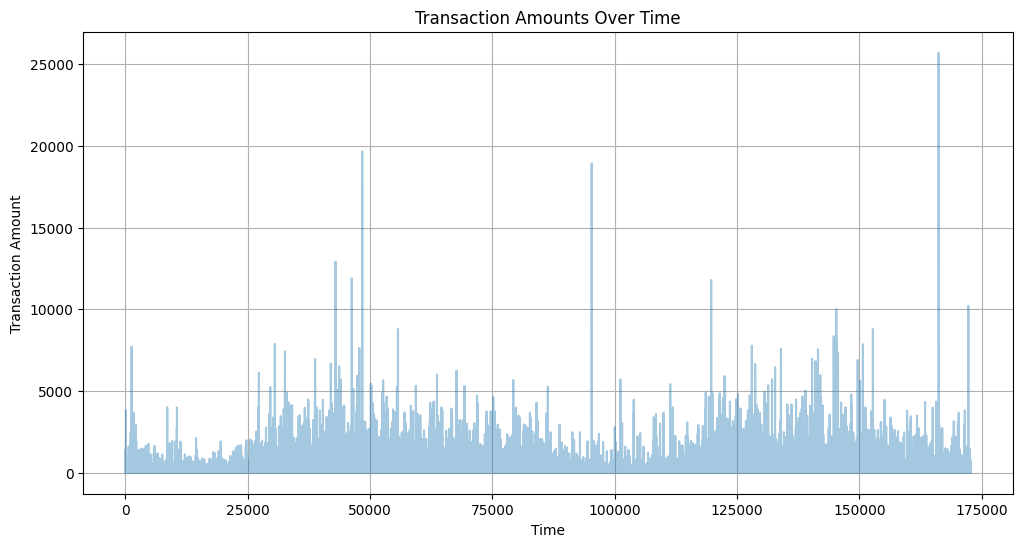

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['Time'], df['Amount'], alpha=0.4)
plt.title('Transaction Amounts Over Time')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.grid(True)
plt.show()

On voit ici les transactions en fonction du temps, elles sont assez dispersés. On peut observés 3 piques majeurs à environ 50000 secondes d'intervalles, donc ce graphique n'a pas beaucoup de significations je trouve

In [9]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [10]:
df['Hour'] = (df['Time'] // 3600)  % 24
df['Hour'].value_counts()

Hour
21.0    17703
18.0    17039
11.0    16856
20.0    16756
10.0    16598
14.0    16570
15.0    16461
16.0    16453
17.0    16166
9.0     15838
19.0    15649
22.0    15441
12.0    15420
13.0    15365
23.0    10938
8.0     10276
0.0      7695
7.0      7243
1.0      4220
6.0      4101
3.0      3492
2.0      3328
5.0      2990
4.0      2209
Name: count, dtype: int64

On voit que la grande majorité des transactions se font sur une longue durée. Avec cette base de données, on voit que le plus grand intervalle de temps entre deux transactions est de 21h

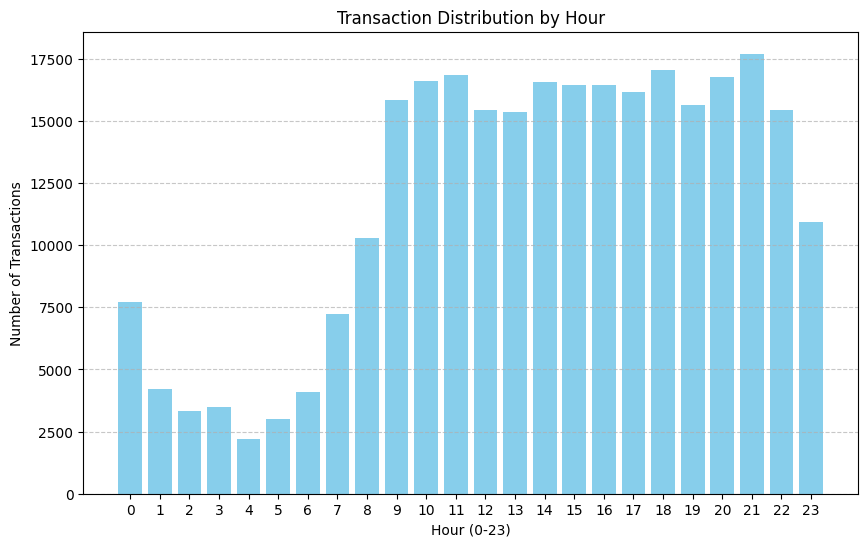

In [11]:
hour_counts = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(hour_counts.index, hour_counts.values, color="skyblue")
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution by Hour')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On voit ici le nombre de transaction en fonction des heures, et on voit que la majorité des transactions se font entre 8 et 23h de temps. On peut oberser qu'ici, entre 1 et 6h, les activités sont vraiment basses, bien que ce soit des heures fictives, cela peut être considéré comme le début de la matinée, du coup, les utilisateurs ne sont pas assez nombreux à faire des transactions. Entre 7 et 9h, on voit un montée rapide, ce qui peut correspondre aux heures auxquels toutes personnes lambda commencent sa journée de travail. Et de 9 à 22h, on obsereve une grande activité, cela peut corespondre aux heures de bureau et de consommatiokn en journée. Et à 23h, on constate une chute brutale. Je vais essayer de voir la distribution des fraudes par heure.

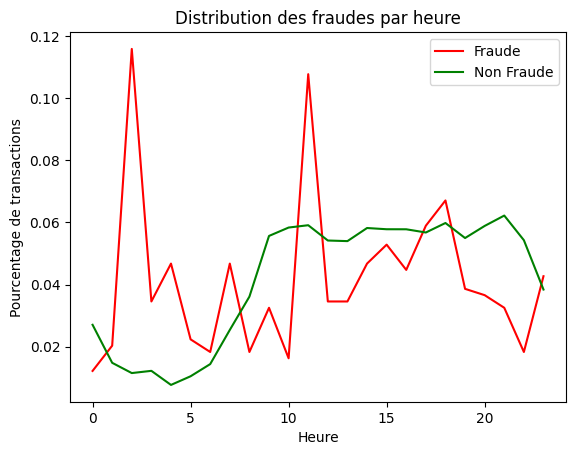

In [14]:
fraude_par_heure = df[df['Class'] == 1]['Hour'].value_counts(normalize=True).sort_index()
non_fraude_par_heure = df[df['Class'] == 0]['Hour'].value_counts(normalize=True).sort_index()

plt.plot(fraude_par_heure, label='Fraude', color='red')
plt.plot(non_fraude_par_heure, label='Non Fraude', color='green')
plt.xlabel('Heure')
plt.ylabel('Pourcentage de transactions')
plt.title('Distribution des fraudes par heure')
plt.legend()
plt.show()


Je remarque que les heures auxquels les fraudes atteignent leurs piques sont entre 0 et 4h, 10 et 12h, et entre 16 et 19h. Je pense que c'est un moment dans lesquels les activités des citoyens lambda sont pas actifs, comme entre 0 et 4h lorsqu'ils sont sensés dormir, entre 10 et 12h lorsqu'ils sont au travail et entre 16 et 19h lorsqu'ils rentrent à la maison. Cela peut s'expliquer par le faite qu'il y ait moins de surveillance pour pouvoir opérer

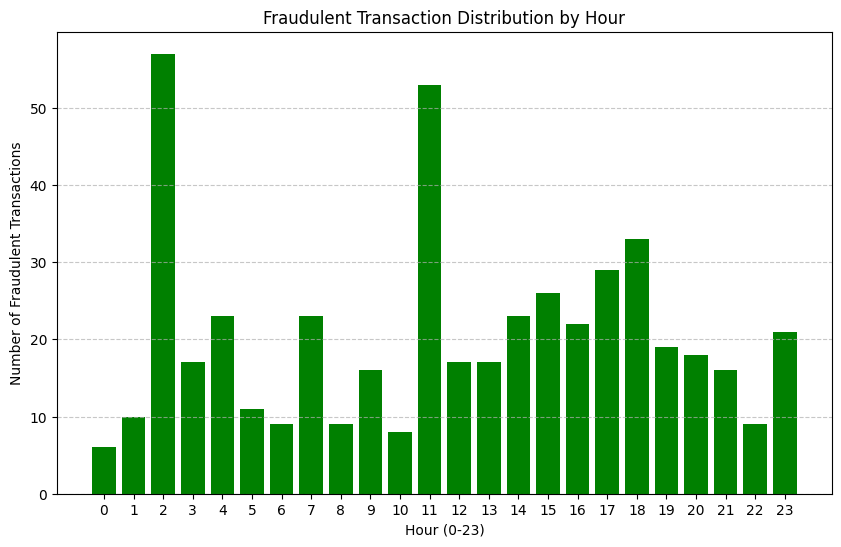

In [15]:
fraud_df = df[df['Class'] == 1]
fraud_hour_counts = fraud_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(fraud_hour_counts.index, fraud_hour_counts.values, color='green')
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transaction Distribution by Hour')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Ce graph vient appuyer l'hypothèse que j'ai émis plus haut, le plus grand nombre de transactions frauduleuses sont à 2, 11 et 18h, des heures dans lesquelles les citoyens baissent en activité car soit ils dorment, soit ils mangent où soit ils rentrent à la maison

In [17]:
pca_columns = [f"V{i}" for i in range(1,29)]

fraud_df = df  

results = []

for col in pca_columns:
    data = fraud_df[col].dropna()
    
    stat, p_normal = normaltest(data)
    normal = p_normal > 0.05
    
    
    if normal:
        corr, p_corr = pearsonr(data, fraud_df['Class'])
        method = 'Pearson'

    else:
        corr, p_corr = spearmanr(data, fraud_df['Class'])
        method = 'Spearman'

    results.append({
        'Feature':col,
        'Method':method,
        'Correlation':corr,
        'p-value':p_corr,
        'Normal_dist':normal
})

results_df = pd.DataFrame(results).sort_values(by='Correlation',key=abs,ascending=False)


print(results_df)

   Feature    Method  Correlation        p-value  Normal_dist
13     V14  Spearman    -0.064613  4.248283e-261        False
3       V4  Spearman     0.063045  1.176139e-248        False
11     V12  Spearman    -0.062870  2.764233e-247        False
10     V11  Spearman     0.060143  1.933534e-226        False
9      V10  Spearman    -0.059564  3.920960e-222        False
2       V3  Spearman    -0.059278  5.025822e-220        False
1       V2  Spearman     0.051062  1.017622e-163        False
15     V16  Spearman    -0.049936  1.161926e-156        False
8       V9  Spearman    -0.049499  5.835988e-154        False
6       V7  Spearman    -0.048308  9.941515e-147        False
16     V17  Spearman    -0.044335  7.006476e-124        False
0       V1  Spearman    -0.042424  1.383101e-113        False
5       V6  Spearman    -0.038410   1.911830e-93        False
20     V21  Spearman     0.035442   7.755802e-80        False
17     V18  Spearman    -0.034872   2.385467e-77        False
4       

Je remarque que les valeurs ne suivent pas la loi normale, et du coup, je vais choisir la methode de Spearman car cette méthode est peu sensible aux valeurs extrêmes de ma base de données contrairement à la methode de pearson qui est beaucoup sensibles aux valeurs aberrantes.

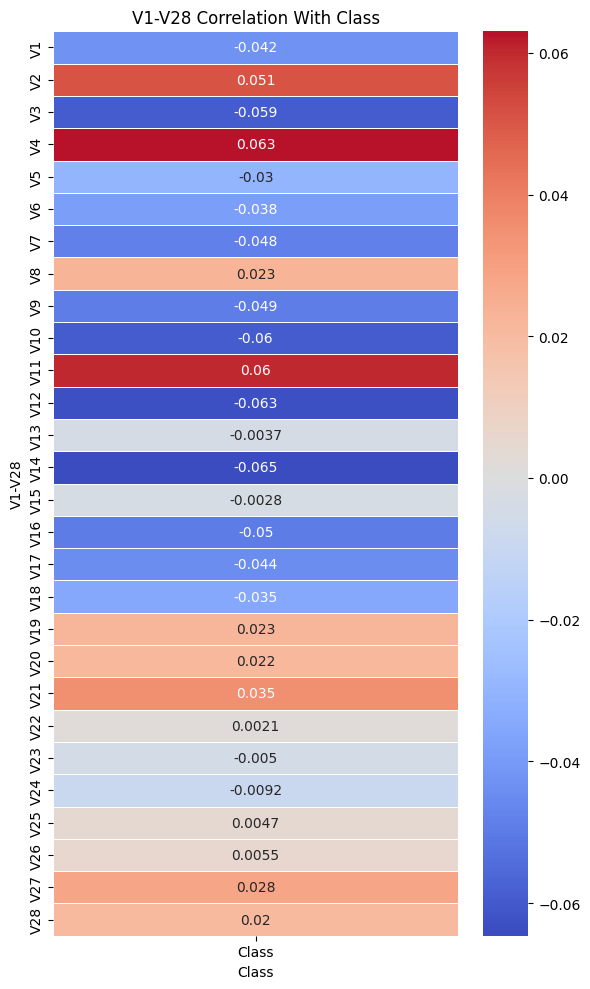

In [18]:
pca_columns = [f"V{i}" for i in range(1, 29)]

corr_matrix = df[pca_columns + ['Class']].corr(method='spearman')

corr_with_class = corr_matrix[['Class']].drop('Class')

plt.figure(figsize=(6, 10))
sns.heatmap(corr_with_class, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("V1-V28 Correlation With Class")
plt.xlabel("Class")
plt.ylabel("V1-V28")
plt.tight_layout()
plt.show()

Dans l'ensemble, il y a que de faibles correlations. Du coup, on ne peut pas concluire qu'avec deux ou trois variables, on peut savoir si cela est une fradue où non, mais on peut dire que lorsque V4 et V11 augmentent légèrement, il y a légère possibilité que ce soit une fraude. Lorsque V10 et V14 diminue, il y a une légère probabilité que ce soit une fraude.

### Note : Interprétation des valeurs de corrélation faibles

Dans l'analyse de corrélation de Spearman ci-dessus, les coefficients de corrélation entre les caractéristiques `V1`-`V28` et l'étiquette `Class` se situent généralement entre -0.06 et +0.06. À première vue, ces valeurs peuvent sembler très faibles, mais cela est dû à la **nature fortement déséquilibrée** de l'ensemble de données.

Dans cet ensemble de données, les cas de fraude ne représentent que **0,172 %** de toutes les transactions. Lorsque l'on calcule la corrélation avec une classe aussi minoritaire, les mesures statistiques ont tendance à montrer des associations faibles, simplement parce que la classe minoritaire a très peu d'échantillons par rapport à la classe majoritaire.

Par conséquent, les faibles valeurs de corrélation ne signifient pas que ces caractéristiques ne sont pas pertinentes pour la détection des fraudes. Il est important de considérer que dans les problèmes de classification déséquilibrée, les mesures de corrélation classiques peuvent ne pas saisir pleinement le pouvoir prédictif des caractéristiques. Il est recommandé d'utiliser des techniques de modélisation appropriées telles que **SMOTE**, **pondération des classes**, ou d'évaluer les modèles à l'aide des métriques **ROC-AUC** et **Precision-Recall**, qui conviennent mieux aux ensembles de données déséquilibrés.

In [19]:
X = df.drop("Class", axis=1)  
y = df["Class"] 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
base_learners = [
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
    ('xgb', XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(class_weight='balanced'))
]

meta_learner = LogisticRegression()

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  
    passthrough=True,  
    n_jobs=-1
)


In [22]:
param_grid = {
    'lr__C' : [0.1, 1.0, 10],
    'xgb__n_estimators': [50,100],
    'lgbm__num_leaves': [31,50],
    'final_estimator__C' : [0.1,1.0,10] 
}

In [23]:
grid = GridSearchCV(
    estimator=stack_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best ROC AUC (Train CV)", grid.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'final_estimator__C': 10, 'lgbm__num_leaves': 31, 'lr__C': 1.0, 'xgb__n_estimators': 50}
Best ROC AUC (Train CV) 0.9227699215127512


C:\Users\Ephrayyy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
best_model = grid.best_estimator_

# Train skorları
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
print("\n--- TRAIN PERFORMANCE ---")
print(classification_report(y_train, y_train_pred))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# Test skorları
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
print("\n--- TEST PERFORMANCE ---")
print(classification_report(y_test, y_test_pred))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))


--- TRAIN PERFORMANCE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.76      0.72      0.74       394

    accuracy                           1.00    227845
   macro avg       0.88      0.86      0.87    227845
weighted avg       1.00      1.00      1.00    227845

ROC AUC (Train): 0.9178981306555524

--- TEST PERFORMANCE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.77      0.75        98

    accuracy                           1.00     56962
   macro avg       0.87      0.88      0.88     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC (Test): 0.9422847782894813


Ici, on peut voir qu'avec ce modèle, ils arrivent à prédire à 100% la class 0 (No Fraude), et à 74% pour la class 1 (fraude). Cela s'explique à cause de la mauvaise repartition de la base de données.

In [25]:
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.79      0.77        98

    accuracy                           1.00     56962
   macro avg       0.87      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9449444539352038


C:\Users\Ephrayyy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Le modèle prédit parfaitement les non-fraudes (classe 0).

Pour les fraudes (classe 1) :

Recall de 0.79 → il détecte 79 % des vraies fraudes.

Précision de 0.75 → parmi les transactions détectées comme fraude, 75 % sont réellement des fraudes.

F1-score = 0.77 pour la classe 1 → bon équilibre entre précision et rappel.

🔥 ROC AUC = 0.9449 :
Excellente performance globale du modèle pour discriminer fraude vs non-fraude, malgré le déséquilibre.

In [26]:
y_train_pred = stack_model.predict(X_train)

In [27]:
train_score = stack_model.score(X_train, y_train)
print("Train Accuracy:", train_score)


Train Accuracy: 0.9991353771204108


In [28]:
test_score = stack_model.score(X_test, y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.9991748885221726


In [29]:
y_test

263020    0
11378     0
147283    0
219439    0
36939     0
         ..
54199     0
184616    0
274532    0
269819    0
64170     0
Name: Class, Length: 56962, dtype: int64

L’analyse des transactions bancaires pour détecter des fraudes repose sur une démarche rigoureuse combinant exploration des données, visualisation et modélisation. En segmentant les données entre transactions frauduleuses et normales, nous avons pu identifier des différences de comportement, notamment sur certaines plages horaires et variables spécifiques.

Grâce à des outils comme les matrices de corrélation, les tests de normalité, et les heatmaps, nous avons mis en évidence des variables légèrement liées à la fraude, telles que V4, V10, V11, et V14. Bien que ces corrélations soient faibles, leur combinaison au sein d’un modèle de machine learning permet une détection efficace.

Le modèle de stacking entraîné atteint une excellente performance (ROC AUC = 0.94), prouvant que la détection de la fraude ne repose pas sur une seule variable, mais sur un ensemble de signaux faibles. Cette approche permet non seulement de détecter les fraudes, mais aussi de comprendre les schémas sous-jacents qui les caractérisent.

Ainsi, une analyse combinant EDA approfondie et modélisation permet de construire des systèmes robustes de détection des fraudes bancaires.

